### generic model for face detection (based on an object detection model)
### model
- `VGG16` - predefined model for object detection
- input 
    - image [200 x 200]
- output 
    - [0,1] - 0 if face is not present on the image, 1 otherwise
    - x,y,w,h - coordinates of the face on the image
### dictionary
- bounding box - box that marks area where our object is present (in our case face)
### libraries 
- `labelme` - Library that contains method that we will use to label data


In [142]:
from pathlib import Path # to get the path of the current file
import time # to measure time
import uuid # for unique id
import cv2
import os
import random

# collect data

In [143]:
DATA_PATH = Path.cwd() / 'data'  # path to the data folder
IMAGES_NUMBER = 0
DATA_PATH.mkdir(parents=True, exist_ok=True)

In [144]:
capture = cv2.VideoCapture(0) # 0 is the default camera
for num in range(IMAGES_NUMBER):
    print(f'Image {num}/{IMAGES_NUMBER}')
    ret, frame = capture.read()
    if ret:
        img_name = str(Path(DATA_PATH / 'images' / f'{uuid.uuid4()}.jpg').resolve())
        cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(.5) 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
capture.release()
#cv2.destroyAllWindows()

In [145]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [146]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [147]:
images = tf.data.Dataset.list_files(str(DATA_PATH /'images'/'*.jpg'))


In [148]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image

In [149]:
images.as_numpy_iterator().next()

b'c:\\Users\\skibi\\Desktop\\project\\data\\images\\310732059_1013788152775947_2884858405834785820_n.jpg'

In [150]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [151]:
images = images.map(load_image)

In [152]:
images.as_numpy_iterator().next().shape

(403, 403, 3)

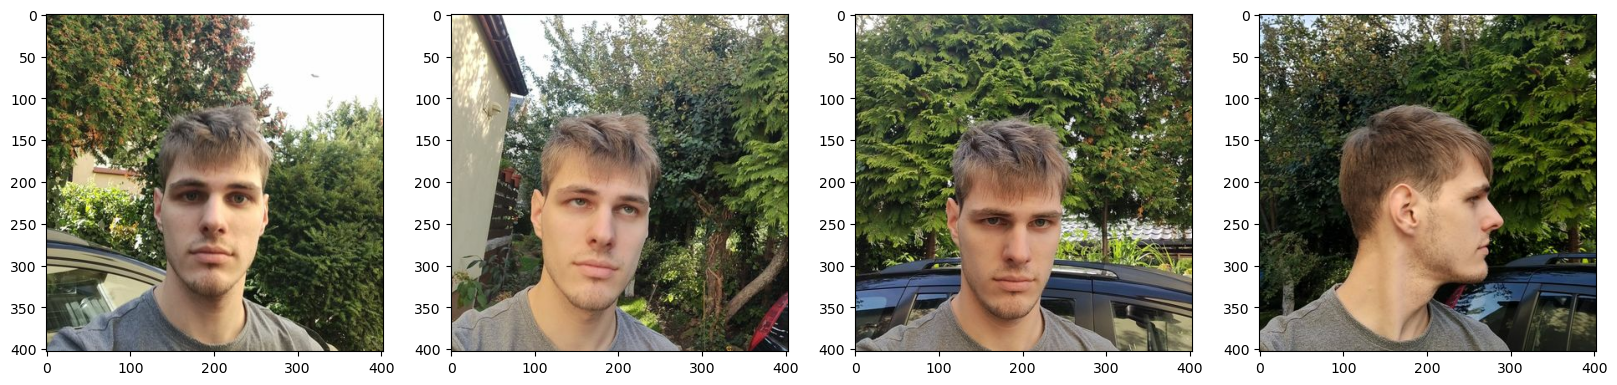

In [153]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## here split data mannualy


In [154]:
for folder in ['train','test']:
    for file in os.listdir(os.path.join(DATA_PATH, folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(DATA_PATH,'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [155]:
import albumentations as alb

In [156]:
augmentor = alb.Compose([alb.RandomCrop(width=403, height=403), 
                        alb.HorizontalFlip(p=0.5), 
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), 
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)], 
                        bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [157]:
image = cv2.imread(os.path.join('data','train','images','310649587_1218860985327644_2650208442576522227_n.jpg'))
image.shape

(403, 403, 3)

In [158]:
with open(os.path.join('data','train','labels','310649587_1218860985327644_2650208442576522227_n.json')) as f:
    label = json.load(f)
label['shapes'][0]['points']

[[5.656903765690373, 118.41004184100417],
 [144.98744769874475, 337.23849372384933]]

In [159]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [160]:
coords = list(np.divide(coords, [403, 403, 403, 403]))

In [161]:
augmented = augmentor(image=image, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[169, 190, 191],
         [171, 192, 193],
         [173, 194, 195],
         ...,
         [175, 179, 180],
         [202, 208, 209],
         [212, 217, 218]],
 
        [[166, 187, 188],
         [169, 190, 191],
         [171, 192, 193],
         ...,
         [180, 184, 185],
         [205, 211, 212],
         [218, 223, 224]],
 
        [[171, 192, 193],
         [173, 194, 195],
         [175, 196, 197],
         ...,
         [183, 188, 189],
         [209, 214, 215],
         [223, 228, 229]],
 
        ...,
 
        [[ 45,  48,  56],
         [ 50,  53,  61],
         [ 57,  59,  68],
         ...,
         [182, 234, 250],
         [182, 234, 250],
         [183, 235, 251]],
 
        [[ 33,  36,  44],
         [ 44,  47,  55],
         [ 58,  60,  69],
         ...,
         [183, 234, 252],
         [183, 234, 252],
         [184, 235, 254]],
 
        [[  8,  11,  19],
         [ 25,  28,  36],
         [ 43,  45,  53],
         ...,
         [183, 234,

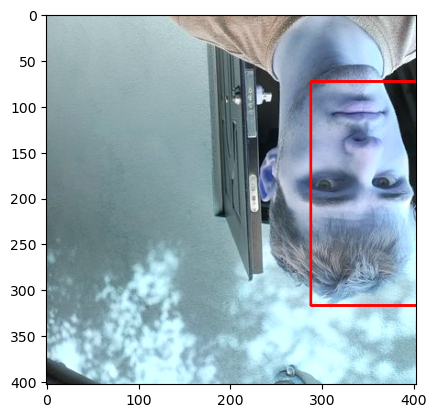

In [162]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [403,403]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [403,403]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [163]:
def save_images():
    for partition in ['train','test']: 
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))

            coords = [0,0,0.00001,0.00001]
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)

                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [403, 403, 403, 403]))

            try: 
                for x in range(60):
                    augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                    annotation = {}
                    annotation['image'] = image

                    if os.path.exists(label_path):
                        if len(augmented['bboxes']) == 0: 
                            annotation['bbox'] = [0,0,0,0]
                            annotation['class'] = 0 
                        else: 
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                    else: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 


                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)

            except Exception as e:
                print(e)
save_images()